In [1]:
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt

import sgkit as sg

import tszip

import sys
sys.path.append("../../tsimpute/src/")
import impute_by_sample_matching as impute


In [2]:
trees_dir = "../data/trees/"
zarr_dir = "../data/zarr/"
vcf_dir = "../data/vcf/"
lshmm_dir = "../analysis/lshmm/"


In [3]:
ref_ts_file = trees_dir + "ref.tsz"
ref_ts = tszip.decompress(ref_ts_file)


In [4]:
target_chip_ds_compat = sg.load_dataset(zarr_dir + "target_chip_compat.zarr")
target_chip_ds_compat


<xarray.Dataset>
Dimensions:             (variants: 7899, samples: 176, ploidy: 2, contigs: 1,
                         alleles: 4)
Dimensions without coordinates: variants, samples, ploidy, contigs, alleles
Data variables:
    call_genotype       (variants, samples, ploidy) float64 dask.array<chunksize=(1975, 44, 1), meta=np.ndarray>
    call_genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(3950, 88, 1), meta=np.ndarray>
    contig_id           (contigs) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    sample_id           (samples) object dask.array<chunksize=(176,), meta=np.ndarray>
    variant_allele      (variants, alleles) <U1 dask.array<chunksize=(7899, 4), meta=np.ndarray>
    variant_contig      (variants) int8 dask.array<chunksize=(7899,), meta=np.ndarray>
    variant_position    (variants) int32 dask.array<chunksize=(7899,), meta=np.ndarray>
Attributes:
    contigs:  ['20']
    source:   sgkit-0.7.0

In [6]:
def run_lshmm(rho, mu, precision=25):
    switch_prob = np.repeat(rho, ref_ts.num_sites)
    mismatch_prob = np.repeat(mu, ref_ts.num_sites)

    _, h2, _ = impute.impute_by_sample_matching(
        ref_ts=ref_ts,
        target_ds=target_chip_ds_compat,
        switch_prob=switch_prob,
        mismatch_prob=mismatch_prob,
        precision=precision,
    )

    return h2


### Get paths by maintaining rho / mu (not MMR)

In [7]:
h2_r08_m08 = run_lshmm(rho=1e-08, mu=1e-08)


100%|██████████| 504314/504314 [00:05<00:00, 91834.22it/s] 


In [8]:
h2_r07_m07 = run_lshmm(rho=1e-07, mu=1e-07)


100%|██████████| 504314/504314 [00:03<00:00, 152377.39it/s]


In [9]:
h2_r06_m06 = run_lshmm(rho=1e-06, mu=1e-06)


100%|██████████| 504314/504314 [00:03<00:00, 149865.58it/s]


In [44]:
h2_r03_m03 = run_lshmm(rho=1e-03, mu=1e-03)


100%|██████████| 504314/504314 [00:03<00:00, 146051.61it/s]


In [46]:
# Use numpy.savez_compressed instead
out_dir = "../analysis/lshmm/explore/"
np.save(out_dir + "h2_r08_m08.npy", h2_r08_m08)
np.save(out_dir + "h2_r07_m07.npy", h2_r07_m07)
np.save(out_dir + "h2_r06_m06.npy", h2_r06_m06)
np.save(out_dir + "h2_r03_m03.npy", h2_r03_m03)


In [47]:
def get_num_diff_switches_per_haplotype(h1, h2):
    assert h1.shape == h2.shape
    num_diff_switches = np.zeros(h1.shape[0], dtype=np.int32)
    for i in np.arange(h1.shape[0]):
        num_diff_switches[i] = np.sum(np.invert(np.equal(h1[i, :], h2[i, :])))
    return num_diff_switches


In [48]:
# Differences between haplotypes inferred under different parameters
print(h2_r08_m08.shape)
diffs_08_07 = get_num_diff_switches_per_haplotype(h2_r08_m08, h2_r07_m07)
diffs_08_06 = get_num_diff_switches_per_haplotype(h2_r08_m08, h2_r06_m06)
diffs_07_06 = get_num_diff_switches_per_haplotype(h2_r07_m07, h2_r06_m06)
diffs_06_03 = get_num_diff_switches_per_haplotype(h2_r06_m06, h2_r03_m03)


(352, 504314)


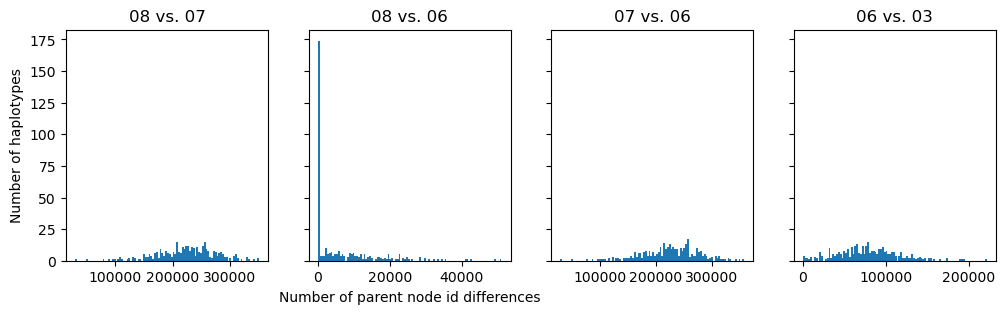

In [49]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
ax1.set_title("08 vs. 07")
ax1.hist(diffs_08_07, bins=100)
ax2.set_title("08 vs. 06")
ax2.hist(diffs_08_06, bins=100)
ax3.set_title("07 vs. 06")
ax3.hist(diffs_07_06, bins=100)
ax4.set_title("06 vs. 03")
ax4.hist(diffs_06_03, bins=100)
ax1.set_ylabel("Number of haplotypes")
ax2.set_xlabel("Number of parent node id differences");


### Get paths by maintaing MMR (or k)

In [52]:
import math

def compute_rho(mu, n, k):
    a = n * mu**k
    b = (1 - mu)**k + (n - 1) * mu**k
    rho = a / b
    return rho

def compute_k(mu, rho, n):
    a = math.log((rho/n) / (1 - rho + rho/n))
    b = math.log(mu / (1 - mu))
    k = a / b
    return k


In [53]:
X1 = compute_rho(mu=1e-08, n=1_400, k=1)
print(X1)
h2_rX1_m08 = run_lshmm(rho=X1, mu=1e-08)


1.3999804282736129e-05


100%|██████████| 504314/504314 [00:04<00:00, 121594.58it/s]


In [54]:
X2 = compute_rho(mu=1e-07, n=1_400, k=1)
print(X2)
h2_rX2_m08 = run_lshmm(rho=X1, mu=1e-07)


0.0001399804307357831


100%|██████████| 504314/504314 [00:04<00:00, 125276.39it/s]


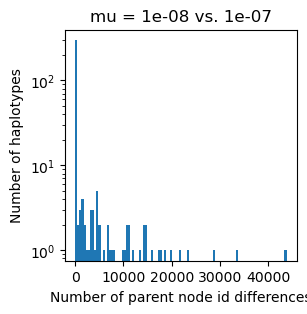

In [56]:
diffs_X1_X2 = get_num_diff_switches_per_haplotype(h2_rX1_m08, h2_rX2_m08)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.set_title("mu = 1e-08 vs. 1e-07")
ax.hist(diffs_X1_X2, bins=100, log=True)
ax.set_ylabel("Number of haplotypes")
ax.set_xlabel("Number of parent node id differences");
